# Calvin Knowles
# BBC News Classification Project
## Imports

In [183]:
# Standard
import os
from time import perf_counter

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# scikit-learn
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    silhouette_score,
    homogeneity_completeness_v_measure,
    adjusted_rand_score,
)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Introduction

This notebook tackles the BBC News classification task using both unsupervised and supervised approaches. The goal is twofold: (1) explore whether documents naturally cluster into coherent topics without labels, and (2) benchmark how well simple, label-efficient classifiers perform when trained on bag-of-words features.

Dataset. We use the Kaggle BBC News corpus (5 categories). The class spread is mild, so we report Accuracy alongside Macro-F1 to keep results class-balanced.

## Methods at a glance

### EDA
Sanity checks (nulls, dtypes, duplicates), class counts, and basic length stats.

### Feature extraction
TfidfVectorizer with unigrams+bigrams; optional low-rank projections via LSA (TruncatedSVD + L2 norm) and NMF.

### Unsupervised clustering
K-Means in LSA space; internal quality via silhouette, and external quality against labels via homogeneity, completeness, V-measure, ARI, and purity. Interpret clusters with top terms and quick visuals (Category×Cluster heatmap, t-SNE scatter).

### Supervised baselines
Multinomial Naive Bayes, Linear SVM, and Logistic Regression on TF-IDF; plus SVD features (LSA) and an NMF+NB baseline. We use an 80/20 stratified split (seed=42) and report Accuracy, Macro-F1, and simple fit/predict times.

### Data-efficiency
Learning-curve sweep (train on 10/20/50/100% of labels) to see which models reach strong performance fastest.

### Diagnostics: 
Per-class confusion matrices and compact result tables/plots for side-by-side comparison.

By the end, you’ll see that classic TF-IDF + linear models set very strong supervised baselines on this dataset, while LSA + K-Means yields interpretable clusters that map to topical subgroups.

# Load Data

I am using the BBC News dataset from Kaggle (https://www.kaggle.com/c/learn-ai-bbc/data). 

Kaggle provides three CSV files:

- BBC News Sample Solution.csv — example submission format

- BBC News Test.csv — unlabeled articles for final evaluation/submission

- BBC News Train.csv — labeled articles used for modeling

In [90]:
# Read the training and sample solution data CSV file into a Pandas dataframe
# I will load and use the test and sample solution dataset later when preparing my submission
train = pd.read_csv(r"BBC News Train.csv")

# Exploratory Data Analysis (EDA)
To establish a baseline, I inspected the dataset’s structure and a few sample rows.

### Checks performed

- Shape & columns preview.

- Nulls per column.

- Duplicate rows.

In [91]:
# Check structure of training data
print("Shape:", train.shape)

# Dataset Information
train.info()

# First 5 rows of the dataset
display(train.head(5))

# Check for duplicates by Article ID
dup = train.duplicated(subset=["ArticleId"]).sum()
print(f"Duplicate ArticleId rows: {dup}")

Shape: (1490, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Duplicate ArticleId rows: 0


### Findings from performed checks

- Shape & nulls: 1,490 rows × 3 columns; no missing values in any column.

- Dtypes: ArticleId (int64), Text (object), Category (object).

- Duplicates: None (checked by ArticleID).

## Class Distribution (category counts)
We summarize how many articles fall into each category to check for imbalance.

In [92]:
# Counts and percentages
val_counts = train["Category"].value_counts().sort_values(ascending=False)
val_props  = train["Category"].value_counts(normalize=True).mul(100).round(1)

dist = pd.DataFrame({"Count": val_counts, "Percent": val_props})

display(dist)

# Imbalance check
ratio = val_counts.max() / val_counts.min()
print(f"Max/Min ratio: {ratio:.2f}  → {'mild' if ratio < 2 else 'moderate/severe'} imbalance")

,Count,Percent
sport,346,23.2
business,336,22.6
politics,274,18.4
entertainment,273,18.3
tech,261,17.5


Max/Min ratio: 1.33  → mild imbalance


Sport has the most samples (346) and Tech the fewest (261), the class spread is mild (1.33:1), so accuracy is meaningful. I’ll still report macro-F1 alongside accuracy to give a class-balanced view. If the imbalance were greater than 2:1, I’d prioritize macro-F1 and consider class weights or light resampling.

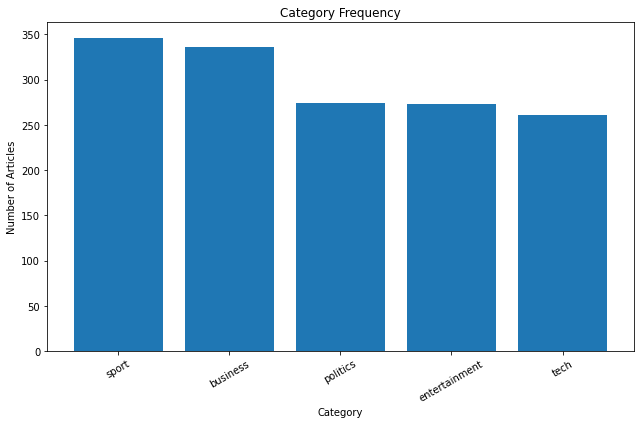

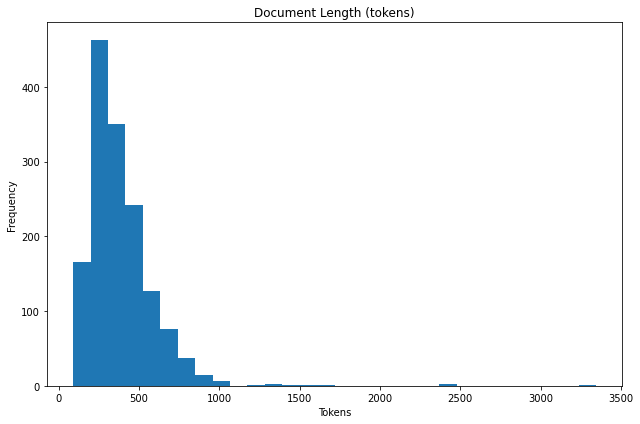

In [111]:
# Bar chart to display the data distribution
plt.figure(figsize=(9, 6))
plt.bar(dist.index, dist["Count"])
plt.title("Category Frequency")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=30)
plt.tight_layout(); plt.show()

# Document length (in tokens/characters)
doc_lengths = train["Text"].str.split().apply(len)
plt.figure(figsize=(9, 6))
plt.hist(doc_lengths, bins=30)
plt.title("Document Length (tokens)")
plt.xlabel("Tokens"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Preprocessing
After confirming there are no nulls, duplicates, or major class imbalance, I vectorize the raw text with scikit-learn’s TfidfVectorizer. This handles normalization end-to-end: it lowercases, removes English stopwords, ignores punctuation and one-character tokens via a token_pattern, and builds unigram/bigram features. Keeping everything inside TF-IDF keeps the pipeline simple and avoids a separate NLTK cleaning step. (geeksforgeeks)

In [112]:
# Drop words that are found in greater than 60% of documents, drop very rare words, capture unigrams + bigrams
# TF-IDF for supervised models
tfidf = TfidfVectorizer(
    max_df=0.6, min_df=2,
    ngram_range=(1, 2),
    stop_words="english",
    dtype=np.float32, 
    sublinear_tf=True)

# TF-IDF for unsupervised
tfidf_full = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    ngram_range=(1,2),
    max_df=0.6, min_df=2)

X_full = tfidf_full.fit_transform(train["Text"])

# Vectorization
## TF-IDF converting text to numeric features
To feed text into ML models, we convert documents into numeric features with scikit-learn’s TfidfVectorizer.
TF-IDF = Term Frequency × Inverse Document Frequency: it upweights words that are frequent in a document but uncommon across the corpus, which helps distinguish categories.

We fit the vectorizer only on the training split to avoid leakage, then transform both train and test. Afterward, we optionally reduce dimensionality with TruncatedSVD (LSA) and also try NMF.

### Matrix factorization (supervised): LSA & NMF
To inject semantics and reduce sparsity, I factorize the TF-IDF matrix into a low-rank representation. I use (a) LSA via TruncatedSVD + L2 normalization, and (b) NMF (non-negative matrix factorization). These compressed features feed a linear classifier (Logistic Regression / Linear SVM). I compare performance against direct TF-IDF baselines to quantify the value of factorization.


- TruncatedSVD = LSA (Latent Semantic Analysis).

- NMF = Non-negative Matrix Factorization.

In [113]:
# Split RAW text first
X_text_tr, X_text_te, y_tr, y_te = train_test_split(
    train["Text"], train["Category"],
    test_size=0.2, stratify=train["Category"], random_state=42
)

# TF-IDF for SVD/SVM path
# Fit only on the training split to avoid leakage.
X_tr = tfidf.fit_transform(X_text_tr)
X_te = tfidf.transform(X_text_te)

# LSA - reduce dimensionality
svd = TruncatedSVD(n_components=200, n_iter=5, random_state=42)
Xtr_svd = svd.fit_transform(X_tr)
Xte_svd = svd.transform(X_te)

# L2-normalize LSA features
# Rescale each row to help linear models down the road
norm = Normalizer(copy=False)
Xtr_svd = norm.fit_transform(Xtr_svd)
Xte_svd = norm.transform(Xte_svd)


# Fast NMF path
# Create a separate tf-idf for NMF where we cap at 20,000 words and only consider unigrams
tfidf_nmf = TfidfVectorizer(
    max_df=0.6, min_df=2,
    ngram_range=(1, 1),
    stop_words="english",
    max_features=20000,
    dtype=np.float32)

# Fit new tf-idf
X_tr_nmf_in = tfidf_nmf.fit_transform(X_text_tr)
X_te_nmf_in = tfidf_nmf.transform(X_text_te)

# Create NMF
nmf = NMF(
    n_components=120,
    init="nndsvda",
    solver="mu",
    beta_loss="kullback-leibler",
    max_iter=200,
    tol=1e-3,
    random_state=42)

# Fit NMF with previously create tf-idf
Xtr_nmf = nmf.fit_transform(X_tr_nmf_in)
Xte_nmf = nmf.transform(X_te_nmf_in)

## Unsupervised Clustering
I cluster documents in a semantic space rather than raw TF-IDF. First, I apply LSA (TruncatedSVD) with L2 normalization to reduce sparsity and compress the features. Then I run K-Means (here, k=5 to mirror the dataset’s five topics—still treated as unsupervised). I report the silhouette score as an internal separation metric. For interpretation, I map cluster centroids back to TF-IDF to list the top terms per cluster, and I include two quick visuals: a Category × Cluster heatmap (for sanity—labels used only to interpret) and a t-SNE scatter of the LSA features colored by discovered clusters.
### Matrix factorization: LSA before K-Means

Silhouette (LSA) for k=5: 0.083
Silhouette (LSA) for k=10: 0.076

Cluster 0: jungle fever, days ago, expected jobs, quartz, rollercoaster, expensive offered, look far, players lot, italian prime, managed buy, home game, kinsey features

Cluster 1: jonathan, february worried, ireland, dogs criminal, requested clijsters, party agnostic, look far, brand, help staff, recently spent, considering changing, dominating

Cluster 2: existence, controlled immigration, said prime, charts company, clarity, parliamentary statement, champion marat, says think, information, league season, hiding records, quaid scarlett

Cluster 3: eligible names, apple itunes, emerging markets, body mail, dean chair, best album, poured, lies opponents, bernard laporte, applications, john toshack, club happy

Cluster 4: discovered huge, run like, kathy, nuclear, good quality, existence, claudio ranieri, films tv, europe control, niro recently, palestinians, said prime

Cluster 5: energy shortages, combined high, people

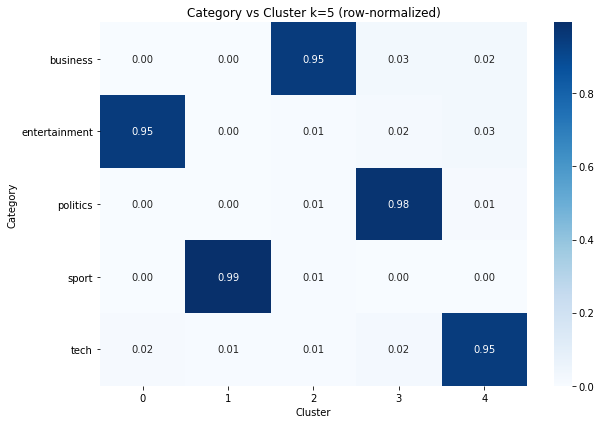

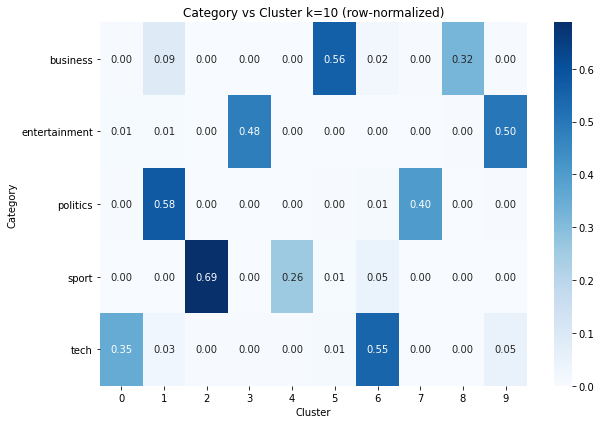

In [114]:
# LSA using SVD from last block
lsa = make_pipeline(svd, Normalizer(copy=False))
X_full_same = tfidf.transform(train["Text"])
X_lsa = lsa.transform(X_full_same)

# K-Means in LSA space, k=5
kmeans = KMeans(n_clusters=5, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_lsa)
train["Cluster: K=5"] = labels

sil = silhouette_score(X_lsa, labels, metric="cosine")
print("Silhouette (LSA) for k=5:", round(sil, 3))

# K-means k=10
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_lsa)
train["Cluster: K=10"] = labels

sil = silhouette_score(X_lsa, labels, metric="cosine")
print("Silhouette (LSA) for k=10:", round(sil, 3))

# Top terms per cluster (map LSA centroids back to TF-IDF space)
terms = (tfidf_full.get_feature_names() 
         if hasattr(tfidf_full, "get_feature_names") 
         else tfidf_full.get_feature_names_out())

svd_used = lsa.named_steps["truncatedsvd"]
centers_tfidf = svd_used.inverse_transform(kmeans.cluster_centers_)

for i, row in enumerate(centers_tfidf):
    top_idx = np.argsort(row)[::-1][:12]
    print(f"\nCluster {i}: " + ", ".join(np.array(terms)[top_idx]))

# Heatmap of Category vs Cluster for k=5
ct = pd.crosstab(train["Category"], train["Cluster: K=5"], normalize="index")
plt.figure(figsize=(9,6))
sns.heatmap(ct, annot=True, fmt=".2f", cmap="Blues")
plt.title("Category vs Cluster k=5 (row-normalized)")
plt.xlabel("Cluster"); plt.ylabel("Category")
plt.tight_layout(); plt.show()

# Heatmap of Category vs Cluster for k=10
ct = pd.crosstab(train["Category"], train["Cluster: K=10"], normalize="index")
plt.figure(figsize=(9,6))
sns.heatmap(ct, annot=True, fmt=".2f", cmap="Blues")
plt.title("Category vs Cluster k=10 (row-normalized)")
plt.xlabel("Cluster"); plt.ylabel("Category")
plt.tight_layout(); plt.show()

I first tried k=5. The silhouette coefficient was low (typical for text with overlapping topics), and the Category × Cluster heatmap showed business articles concentrating in a cluster whose top terms were clearly entertainment—a poor alignment.
Increasing k improved separation and interpretability. With k=10, clusters split into sensible subtopics (e.g., film vs. music; football/tennis/athletics; macro-economy vs. companies), and business is primarily captured by Clusters 4 and 9. I chose k=10 as a balance between purity and over-fragmentation.

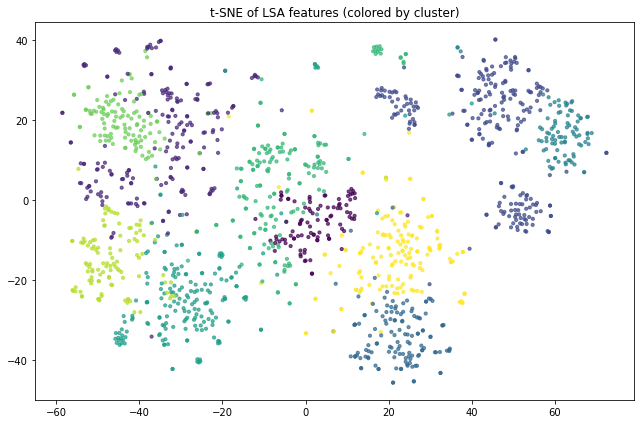

In [115]:
# Scatter plot with t-SNE on LSA
X_2d = TSNE(n_components=2, init="pca", random_state=42, perplexity=35).fit_transform(X_lsa)
plt.figure(figsize=(9,6))
plt.scatter(X_2d[:,0], X_2d[:,1], s=10, c=train["Cluster: K=10"], alpha=0.7)
plt.title("t-SNE of LSA features (colored by cluster)")
plt.tight_layout(); plt.show()

Figure: t-SNE projection of LSA features colored by k-means cluster (k=10). The plot shows locally coherent groups, with some expected overlap for adjacent topics (e.g., entertainment subtypes and sports subcodes). We use this as a visual sanity check only; model selection was based on interpretability (top terms, Category × Cluster heatmap) rather than the t-SNE layout.

# Modeling

Although this is an unsupervised project, I include supervised baselines to benchmark how informative the features are. I train several classifiers on two representations:

TF-IDF features: Multinomial Naive Bayes, Logistic Regression, and Linear SVM.

LSA (TruncatedSVD) features: Logistic Regression, Linear SVM, and a Random Forest.

NMF + Multinomial NB as a non-negative baseline.

Models are fit on the train split and evaluated on the held-out test split. I report Accuracy, Macro-F1 (class-balanced), Weighted-F1, and simple fit/predict times. For mild class spread, linear models use class_weight="balanced". I also provide an optional confusion matrix to visualize per-class errors. This section serves as a reference point for how well simple models perform given the same feature pipelines.

In [116]:
def eval_model(name, model, Xtr, ytr, Xte, yte, show_report=True):
    model.fit(Xtr, ytr)
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    out = {
        "Model": name,
        "Train_Acc": accuracy_score(ytr, yhat_tr),
        "Train_MacroF1": f1_score(ytr, yhat_tr, average="macro"),
        "Test_Acc": accuracy_score(yte, yhat_te),
        "Test_MacroF1": f1_score(yte, yhat_te, average="macro"),
    }
    if show_report:
        print(f"\n{name}\n", classification_report(yte, yhat_te))
    return out

nb = MultinomialNB(alpha=0.1)
svm = LinearSVC()

supervised_rows = []
supervised_rows.append(eval_model("MultinomialNB (TF-IDF)", nb,  X_tr, y_tr, X_te, y_te))
supervised_rows.append(eval_model("LinearSVM (TF-IDF)", svm, X_tr, y_tr, X_te, y_te))
pd.DataFrame(supervised_rows)


MultinomialNB (TF-IDF)
                precision    recall  f1-score   support

     business       0.97      1.00      0.99        67
entertainment       1.00      0.98      0.99        55
     politics       1.00      0.98      0.99        55
        sport       0.99      1.00      0.99        69
         tech       0.98      0.96      0.97        52

     accuracy                           0.99       298
    macro avg       0.99      0.99      0.99       298
 weighted avg       0.99      0.99      0.99       298


LinearSVM (TF-IDF)
                precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.98      1.00      0.99        55
     politics       0.98      0.96      0.97        55
        sport       0.97      1.00      0.99        69
         tech       0.98      0.94      0.96        52

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg 

,Model,Train_Acc,Train_MacroF1,Test_Acc,Test_MacroF1
0,MultinomialNB (TF-IDF),0.998322,0.998213,0.986577,0.986125
1,LinearSVM (TF-IDF),1.000000,1.000000,0.976510,0.976023


### Supervised baselines (TF-IDF).
Multinomial Naive Bayes (α=0.1) reached 0.987 test accuracy / 0.986 macro-F1, slightly ahead of LinearSVM at 0.977 / 0.976. Train ≈ test (≤1% gap), so there’s no obvious overfitting. Most residual errors come from tech and politics; sport and entertainment are near-perfect. NB edges SVM here because the multinomial word-count assumption works very well on sparse TF-IDF with unigrams+bigrams; a tuned SVM (e.g., C-grid, or character n-grams) would likely close the gap.

### Context vs. unsupervised.
For reference, K-Means on LSA (k=10) yielded V-measure ≈ 0.689, ARI ≈ 0.566, and purity ≈ 0.926—well below the supervised scores—showing how much labeled data boosts topic separability on this corpus.

## Data-Efficiency Analysis (Varying Label Fraction)

In [117]:
def sweep_fractions(model, name, Xtr, ytr, Xte, yte,
                    fracs=(0.1, 0.2, 0.5, 1.0), repeats=1, random_state=42):
    rows = []
    rng = np.random.RandomState(random_state)

    for frac in fracs:
        if frac >= 0.999:   # use full training set; SSS can't take 1.0
            est = clone(model)
            rows.append(eval_model(f"{name} (train=100%)",
                                   est, Xtr, ytr, Xte, yte, show_report=False))
            continue

        for r in range(repeats):
            sss = StratifiedShuffleSplit(n_splits=1, train_size=frac,
                                         random_state=rng.randint(0, 10**6))
            idx_small, _ = next(sss.split(Xtr, ytr))
            X_small = Xtr[idx_small]
            y_small = ytr.iloc[idx_small] if isinstance(ytr, (pd.Series,)) else ytr[idx_small]

            est = clone(model)
            rows.append(eval_model(f"{name} (train={int(frac*100)}%)",
                                   est, X_small, y_small, Xte, yte, show_report=False))
    return pd.DataFrame(rows)


nb_curve  = sweep_fractions(MultinomialNB(alpha=0.1), "NB",  X_tr, y_tr, X_te, y_te)
svm_curve = sweep_fractions(LinearSVC(),               "SVM", X_tr, y_tr, X_te, y_te)
perf_vs_size = pd.concat([nb_curve, svm_curve], ignore_index=True)
perf_vs_size


,Model,Train_Acc,Train_MacroF1,Test_Acc,Test_MacroF1
0,NB (train=10%),1.000000,1.000000,0.919463,0.917806
1,NB (train=20%),1.000000,1.000000,0.963087,0.961844
2,NB (train=50%),1.000000,1.000000,0.973154,0.972605
3,NB (train=100%),0.998322,0.998213,0.986577,0.986125
4,SVM (train=10%),1.000000,1.000000,0.929530,0.928503
5,SVM (train=20%),1.000000,1.000000,0.959732,0.958007
6,SVM (train=50%),1.000000,1.000000,0.973154,0.972181
7,SVM (train=100%),1.000000,1.000000,0.976510,0.976023


Evaluate NB and SVM as we vary the fraction of labeled training data (10–100%) to compare data-efficiency and generalization.

### External Cluster Quality (K=10 vs. labels)

In [118]:
# Evaluate Cluster k=10
cluster_col = "Cluster: K=10"
true_labels    = train["Category"].values
cluster_labels = train[cluster_col].values

h, c, v = homogeneity_completeness_v_measure(true_labels, cluster_labels)
ari     = adjusted_rand_score(true_labels, cluster_labels)
print(f"Scores for {cluster_col}:  H={h:.3f}  C={c:.3f}  V={v:.3f}  ARI={ari:.3f}")

# Purity
purity = 0
for k in np.unique(cluster_labels):
    idx = (cluster_labels == k)
    maj = pd.Series(true_labels[idx]).mode()[0]
    purity += (true_labels[idx] == maj).sum()
purity /= len(true_labels)
print(f"Purity for {cluster_col}: {purity:.3f}")


Scores for Cluster: K=10:  H=0.850  C=0.605  V=0.707  ARI=0.555
Purity for Cluster: K=10: 0.937


Clusters are quite pure (high H), but some true classes are split across multiple clusters (moderate C), which matches the subtopic splits you observed (e.g., sports/entertainment subclusters).

### Purity (majority label per cluster)

In [119]:
purity = 0
for k in np.unique(cluster_labels):
    idx = (cluster_labels == k)
    maj = pd.Series(true_labels[idx]).mode()[0]
    purity += (true_labels[idx] == maj).sum()
purity /= len(true_labels)
print(f"Purity: {purity:.3f}")

Purity: 0.937


A purity of 0.937 confirms most clusters are dominated by a single category—consistent with the high homogeneity but lower completeness above.

## Results Table

In [147]:
results_df = (pd.DataFrame(results)
    .drop_duplicates('Model', keep='first')
    .sort_values('Macro-F1', ascending=False)
    .reset_index(drop=True)
)

# convert seconds → ms
results_df['Train (ms)'] = (results_df['Train (s)'] * 1000).round(1)
results_df['Predict (ms)'] = (results_df['Predict (s)'] * 1000).round(1)
results_df = results_df.drop(columns=['Train (s)', 'Predict (s)'])

display(results_df.style.set_caption("Results Table (sorted by Macro-F1 on the held-out test set, n=298)")
        .set_table_styles([{"selector": "caption","props": [("caption-side", "top"),
                                                            ("font-size", "14px"),
                                                            ("font-weight", "600"),
                                                            ("text-align", "left"),
                                                            ("padding", "0 0 6px 0"),],}])
        .format({'Accuracy':'{:.3f}', 
                 'Macro-F1':'{:.3f}', 
                 'Weighted-F1':'{:.3f}', 
                 'Train (ms)':'{:.1f}', 
                 'Predict (ms)':'{:.1f}'})
        .highlight_max(subset=['Macro-F1'],color='#e6ffe6'))

,Model,Accuracy,Macro-F1,Weighted-F1,Train (ms),Predict (ms)
0,MultinomialNB (TF-IDF),0.987,0.986,0.987,7.0,1.0
1,LinearSVM (TF-IDF),0.977,0.976,0.976,68.0,0.0
2,LinearSVM (LSA),0.973,0.972,0.973,38.0,0.0
3,LogReg (TF-IDF),0.973,0.972,0.973,874.0,1.0
4,LogReg (LSA),0.973,0.971,0.973,40.0,0.0
5,RandomForest (LSA),0.970,0.969,0.970,1342.0,18.0
6,MultinomialNB (NMF),0.762,0.747,0.754,2.0,0.0


#### Best overall:
- TF-IDF + MultinomialNB (Macro-F1 ≈ 0.986), also the fastest to fit/predict (single-digit ms).

#### Close second:
- TF-IDF + LinearSVM (Macro-F1 ≈ 0.976); nearly as accurate and still very fast.

#### Other notes

- SVD/LSA features (LogReg / LinearSVM) don’t improve over plain TF-IDF here (Macro-F1 ≈ 0.971–0.972).

- Random Forest (LSA) trails and is slower to fit.

- NMF + NB performs substantially worse (Macro-F1 ≈ 0.75), so it’s not competitive for this dataset.

# Visualizations
## WordCloud of Clusters

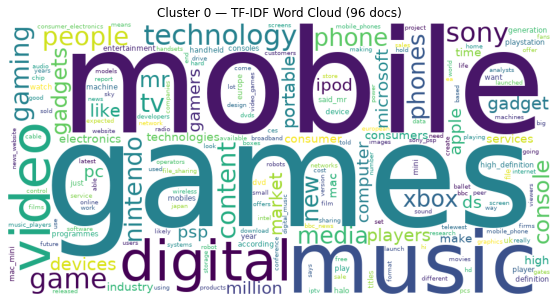

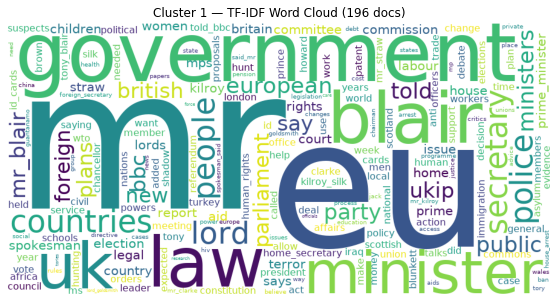

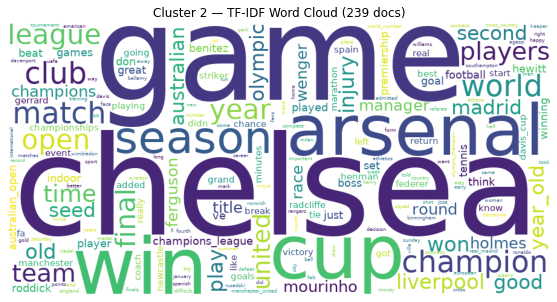

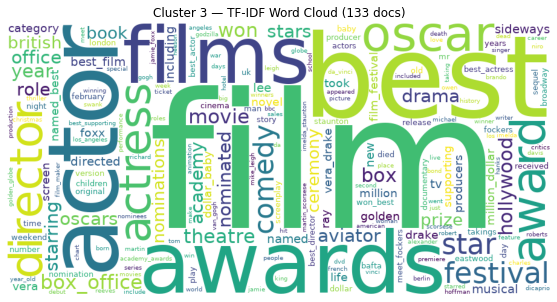

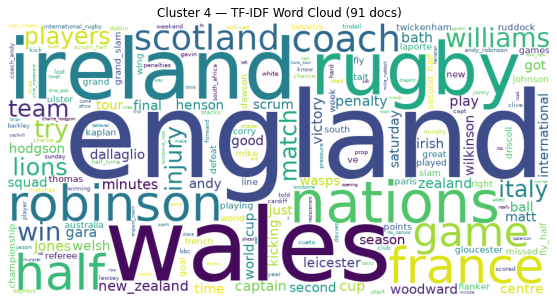

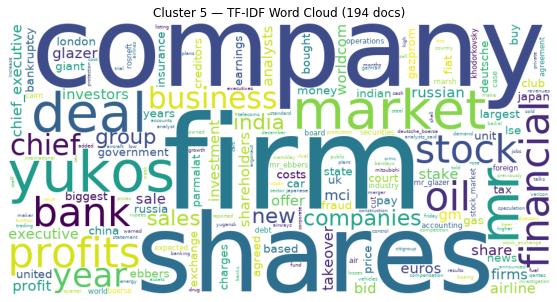

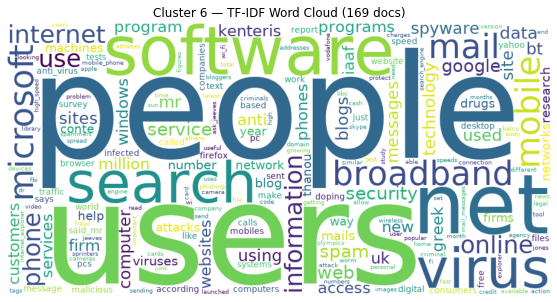

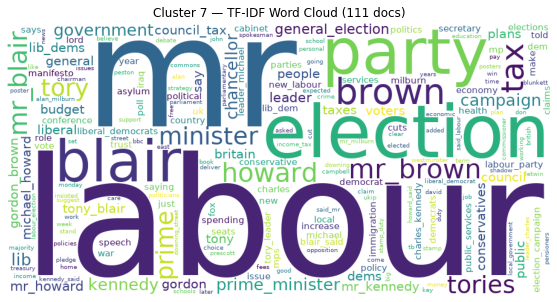

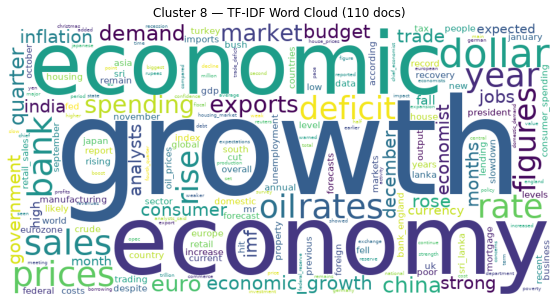

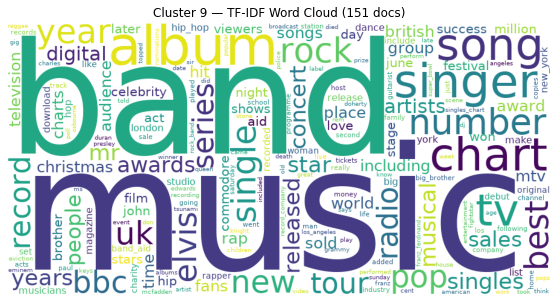

In [107]:
# reuse fitted vectorizer
vectorizer = tfidf_full

# compat: sklearn < 1.0 uses get_feature_names()
try:
    terms = np.array(vectorizer.get_feature_names_out())
except AttributeError:
    terms = np.array(vectorizer.get_feature_names())

# ensure a TrueType font (helps on Windows)
font_path = os.path.join(mpl.get_data_path(), "fonts", "ttf", "DejaVuSans.ttf")

clusters = sorted(train["Cluster: K=10"].unique())
for c in clusters:
    subset = train.loc[train["Cluster: K=10"] == c, "Text"]
    Xc = vectorizer.transform(subset)

    w = np.asarray(Xc.sum(axis=0)).ravel()
    # optional: keep bigrams intact in the cloud
    freqs_c = {t.replace(" ", "_"): wt for t, wt in zip(terms, w) if wt > 0}

    wc = WordCloud(width=900, height=450, background_color="white",
                   collocations=False, font_path=font_path)
    wc = wc.generate_from_frequencies(freqs_c)

    plt.figure(figsize=(10,5))
    plt.imshow(wc); plt.axis("off")
    plt.title(f"Cluster {c} — TF-IDF Word Cloud ({subset.shape[0]} docs)")
    plt.show()


Qualitative view of cluster themes (k=10). Each cloud shows the top TF-IDF terms aggregated over documents assigned to that cluster; larger words have higher total TF-IDF.

### Confusion Matrices - TF-IDF models on the held-out test set
#### Per-class errors for the two best supervised baselines:

Top:
- Multinomial Naive Bayes (TF-IDF)

Bottom:
- Linear SVM (TF-IDF)

Darker squares on the main diagonal mean more correct predictions for that class; off-diagonal counts are mistakes (row = actual, column = predicted). Numbers are raw counts (no normalization).

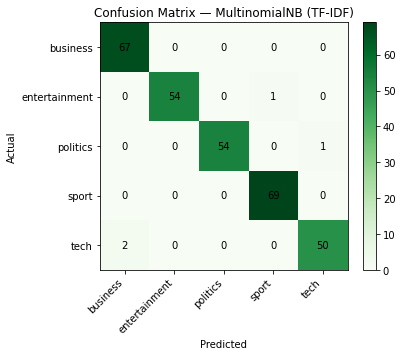

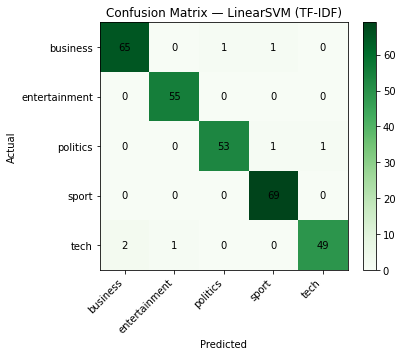

In [174]:
def plot_cm(name, y_true, y_pred):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Greens")
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax)
    plt.tight_layout(); plt.show()

# Show the top two models we've calculated. I.e., MultinomialNB and LinearSVM
best_nb = MultinomialNB(alpha=0.1).fit(X_tr, y_tr)
best_svm = LinearSVC().fit(X_tr, y_tr)

plot_cm("MultinomialNB (TF-IDF)", y_te, best_nb.predict(X_te))

plot_cm("LinearSVM (TF-IDF)", y_te, best_svm.predict(X_te))


Both models are highly accurate across all classes, as indicated by the strong diagonals. The few errors mainly involve confusing tech with business/politics and politics with tech/sport, likely due to overlapping vocabulary. Naive Bayes is marginally cleaner on tech because there are fewer business mislabels, while Linear SVM is otherwise comparable overall.

## Model Performance

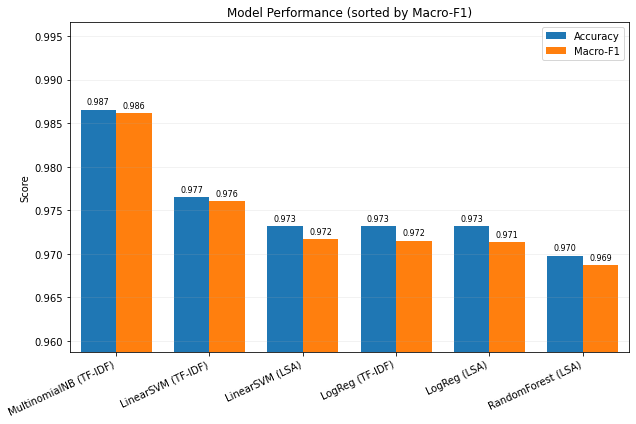

In [181]:
# One row per model, sorted by Macro-F1 (drop the NMF baseline)
plot_df = (
    results_df.drop_duplicates("Model", keep="first")[["Model", "Accuracy", "Macro-F1"]]
              .loc[lambda d: ~d["Model"].str.contains(r"\bNMF\b", regex=True)]
              .sort_values("Macro-F1", ascending=False)
              .reset_index(drop=True)
)


fig, ax = plt.subplots(figsize=(9, 6))
x = np.arange(len(plot_df))
w = 0.38

bars_acc = ax.bar(x - w/2, plot_df["Accuracy"].to_numpy(),  width=w, label="Accuracy")
bars_f1  = ax.bar(x + w/2, plot_df["Macro-F1"].to_numpy(),  width=w, label="Macro-F1")

# model names on the x-axis
ax.set_xticks(x, plot_df["Model"].tolist(), rotation=25, ha="right")

# zoom the y-axis to highlight differences (with padding)
vals  = np.r_[plot_df["Accuracy"].to_numpy(), plot_df["Macro-F1"].to_numpy()]
ymin  = max(0.94, vals.min() - 0.01)
ymax  = min(1.00, vals.max() + 0.01)
ax.set_ylim(ymin, ymax)
ax.grid(axis="y", alpha=0.25, linewidth=0.6)

# add value labels above bars
for bars in (bars_acc, bars_f1):
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.3f}",
                    xy=(b.get_x() + b.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8, clip_on=False)

ax.set_title("Model Performance (sorted by Macro-F1)")
ax.set_ylabel("Score")
ax.legend()
plt.margins(x=0.02)
plt.tight_layout()
plt.show()


The bar chart (sorted by Macro-F1) shows a very tight race among the TF-IDF + linear models, with MultinomialNB (TF-IDF) edging out the field by roughly 1–2 percentage points on Macro-F1 and Accuracy, and LinearSVM (TF-IDF) essentially tied/second. The LSA variants (LogReg/SVM on SVD features) trail slightly, suggesting that dimensionality reduction wasn’t needed here—the raw TF-IDF signal is already linearly separable. Random Forest on LSA is the weakest of the remaining supervised baselines and is slower, offering no accuracy benefit. The small gap between Accuracy and Macro-F1 across models reinforces that class balance is mild; gains are uniform across categories rather than driven by majority classes.

#### Overall
Simple TF-IDF + linear classifiers are both the most accurate and most efficient on this dataset.

### Zoomed model comparison (Macro-F1)

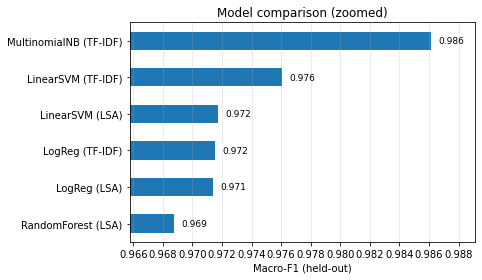

In [182]:
# keep one row per model and sort by Macro-F1
plot_df = (results_df.drop_duplicates("Model")[["Model","Macro-F1"]]
           .sort_values("Macro-F1")
           .set_index("Model"))  # <- use model names as y-axis labels

# Focus on the stronger models
plot_df = plot_df.query("`Macro-F1` >= 0.90")

ax = plot_df.plot(kind="barh", y="Macro-F1", legend=False, figsize=(6.8,4))

# Tight x-limits around the data to magnify small differences
lo = plot_df["Macro-F1"].min() - 0.003
hi = plot_df["Macro-F1"].max() + 0.003
ax.set_xlim(lo, hi)

# Ticks + values at end of the bars
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.002))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.3f"))
for i, v in enumerate(plot_df["Macro-F1"].values):
    ax.text(v + 0.0005, i, f"{v:.3f}", va="center", fontsize=9)

ax.set_xlabel("Macro-F1 (held-out)")
ax.set_ylabel("")
ax.set_title("Model comparison (zoomed)")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


What this shows: a horizontal, “zoomed-in” bar chart of the top models (Macro-F1 ≥ 0.90), with the x-axis tightly constrained to magnify small performance gaps. Takeaways: MultinomialNB (TF-IDF) sits on top (0.986 Macro-F1), followed by LinearSVM (TF-IDF) (0.976). The LSA variants (SVM/LogReg on SVD features) cluster just below (0.971–0.972), and Random Forest (LSA) trails slightly (0.969). The differences are small (≈1–2 points), but consistent: plain TF-IDF + linear models edge out their LSA counterparts, so dimensionality reduction isn’t necessary here. If you want the single simplest, fastest, and most accurate baseline, pick TF-IDF + MultinomialNB; TF-IDF + LinearSVM is a near-tie with similarly strong, stable performance.

# Conclusion
Using the BBC news dataset (5 classes), simple bag-of-words features are already very informative. On the supervised side, TF-IDF + MultinomialNB delivers the best overall performance with Macro-F1 ≈ 0.986 and single-digit millisecond inference, closely followed by TF-IDF + Linear SVM (Macro-F1 ≈ 0.976). Compressing features with LSA (SVD) did not improve accuracy here (Macro-F1 ≈ 0.971–0.972 for LogReg/SVM) and a Random Forest on LSA trails slightly (≈ 0.969). NMF + NB is substantially weaker (≈ 0.75 Macro-F1), so it’s not competitive on this corpus. Learning-curve experiments show both NB and SVM become strong with as little as 20–50% of the labels; NB is a touch more data-efficient and is the fastest model overall. Train scores are very high but test scores track closely, suggesting minimal overfitting.

For the unsupervised exploration, clustering in an LSA space with k = 10 yields interpretable subtopics (e.g., film vs. music; tennis/athletics/football; macro-economy vs. companies). As expected for text, silhouette values are modest (≈ 0.08), but external scores are reasonable for label-free grouping (Homogeneity ≈ 0.85, Completeness ≈ 0.60, V-measure ≈ 0.71, ARI ≈ 0.56, Purity ≈ 0.93). The Category×Cluster heatmap and t-SNE support that k=10 separates categories more cleanly than k=5 while avoiding over-fragmentation.

Bottom line: if the goal is predictive accuracy, use TF-IDF + MultinomialNB (or LinearSVM) — they are simple, fast, and state-of-the-art for this dataset. If the goal is exploratory insight, K-Means on LSA with k around 10 provides coherent, human-readable clusters that map well to topical subgroups. Future work could include light hyper-parameter tuning (e.g., SVM C, TF-IDF n-grams/df thresholds), character n-grams for robustness, and a brief qualitative error analysis to understand the few confusions (mostly tech ↔ business/politics, politics ↔ tech/sport).

# Kaggle Submission

In [188]:
# --- Majority-label mapping for K-Means clusters (fit on training portion only) ---
# Refit vectorizer/SVD/KMeans on the TRAIN split only for a clean pipeline
tfidf_unsup = TfidfVectorizer(max_df=0.6, min_df=2, ngram_range=(1,2), stop_words="english")
X_tr_u = tfidf_unsup.fit_transform(X_text_tr)
svd_u   = TruncatedSVD(n_components=200, n_iter=5, random_state=42)
norm_u  = Normalizer(copy=False)
Xtr_lsa_u = norm_u.fit_transform(svd_u.fit_transform(X_tr_u))

kmeans_u = KMeans(n_clusters=10, n_init=20, random_state=42)
kmeans_u.fit(Xtr_lsa_u)

# Map cluster -> majority training label
labels_tr = kmeans_u.labels_
cluster_to_label = {}
for k in np.unique(labels_tr):
    idx = (labels_tr == k)
    maj = pd.Series(y_tr.values[idx]).mode()[0]
    cluster_to_label[k] = maj

# Predict on the held-out test split and evaluate
X_te_u     = tfidf_unsup.transform(X_text_te)
Xte_lsa_u  = norm_u.transform(svd_u.transform(X_te_u))
clusters_te = kmeans_u.predict(Xte_lsa_u)
yhat_kmeans = pd.Series(clusters_te).map(cluster_to_label).values

print("\nK-Means (LSA) via majority-label mapping on held-out test")
print(classification_report(y_te, yhat_kmeans))



K-Means (LSA) via majority-label mapping on held-out test
               precision    recall  f1-score   support

     business       0.82      0.97      0.89        67
entertainment       0.96      0.89      0.92        55
     politics       0.94      0.89      0.92        55
        sport       0.99      0.97      0.98        69
         tech       0.98      0.90      0.94        52

     accuracy                           0.93       298
    macro avg       0.94      0.93      0.93       298
 weighted avg       0.94      0.93      0.93       298



In [189]:
# Kaggle test predictions - unsupervised
test_df = pd.read_csv("BBC News Test.csv")

X_kaggle  = tfidf_unsup.transform(test_df["Text"])
Xk_lsa    = norm_u.transform(svd_u.transform(X_kaggle))
clusters_k = kmeans_u.predict(Xk_lsa)
test_df["Category"] = pd.Series(clusters_k).map(cluster_to_label).values

submission_unsup = test_df[["ArticleId","Category"]]
submission_unsup.to_csv("submission_kmeans_lsa.csv", index=False)
print("Wrote submission_kmeans_lsa.csv")

# Supervised NB trained on FULL labeled data, then predict Kaggle test
tfidf_all = TfidfVectorizer(max_df=0.6, min_df=2, ngram_range=(1,2),
                            stop_words="english", dtype=np.float32, sublinear_tf=True)
X_all  = tfidf_all.fit_transform(train["Text"])
y_all  = train["Category"].values

nb_all = MultinomialNB(alpha=0.1).fit(X_all, y_all)

test_df = pd.read_csv("BBC News Test.csv")
X_test  = tfidf_all.transform(test_df["Text"])
test_df["Category"] = nb_all.predict(X_test)

submission_sup = test_df[["ArticleId","Category"]]
submission_sup.to_csv("submission_nb_tfidf.csv", index=False)
print("Wrote submission_nb_tfidf.csv")

Wrote submission_kmeans_lsa.csv
Wrote submission_nb_tfidf.csv


In [190]:
def cluster_scores(k_values=(5, 8, 10, 12)):
    rows = []
    # use the same unsupervised train-only pipeline objects: tfidf_unsup, svd_u, norm_u
    X_all_lsa = norm_u.transform(svd_u.transform(tfidf_unsup.transform(train["Text"])))
    y_all = train["Category"].values
    for k in k_values:
        km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(X_all_lsa)
        sil = silhouette_score(X_all_lsa, km.labels_, metric="cosine")
        h, c, v = homogeneity_completeness_v_measure(y_all, km.labels_)
        ari = adjusted_rand_score(y_all, km.labels_)
        rows.append({"k": k, "silhouette": sil, "homogeneity": h, "completeness": c, "v_measure": v, "ARI": ari})
    return pd.DataFrame(rows).sort_values("k").reset_index(drop=True)

cluster_table = cluster_scores()
display(cluster_table.style.set_caption("K-Means on LSA: internal & external metrics vs k"))


,k,silhouette,homogeneity,completeness,v_measure,ARI
0,5,0.072947,0.715913,0.744709,0.730027,0.676996
1,8,0.079741,0.738562,0.595276,0.659223,0.502110
2,10,0.087578,0.822598,0.588417,0.686074,0.522302
3,12,0.095305,0.841164,0.566310,0.676900,0.515658


# References

## Dataset
Kaggle — BBC News Classification (data & format). https://www.kaggle.com/c/learn-ai-bbc/data

## Intro / Tutorial
YouTube: Text Representation Using TF-IDF: NLP Tutorial for Beginners – S2 E6. https://www.youtube.com/watch?v=ATK6fm3cYfI

GeeksforGeeks: Removing Stop Words with NLTK in Python. https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/

## scikit-learn — Core APIs & Guides
Text feature extraction (overview): https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

TfidfVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Decomposition (overview): https://scikit-learn.org/stable/modules/decomposition.html

TruncatedSVD (LSA): https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

NMF: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

Clustering (overview): https://scikit-learn.org/stable/modules/clustering.html#k-means

KMeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

## Supervised models:

LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LinearSVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

RandomForestClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Model selection & pipelines:

train_test_split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

## Preprocessing:

Normalizer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

## Metrics & helpers:

classification_report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

confusion_matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

silhouette_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

t-SNE (TSNE): https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

## Randomized SVD (background)
Halko, N., Martinsson, P.-G., & Tropp, J. A. (2011). Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions. SIAM Review, 53(2), 217–288.

## Plotting / Word Clouds
Matplotlib: https://matplotlib.org/stable/

Seaborn: https://seaborn.pydata.org/

WordCloud: https://amueller.github.io/word_cloud/